# Attention Mechanism

## Objective

In this notebook we will explore the use of attention mechanisms to solve a machine translation task.

The goal of this tutorial is (1) to understand the structure of a sequence-to-sequence model and (2) to identify where and how the attention mechanism intervene in the model archicture.
This tutorial is also an occasion to practice the use of recurrent neural network in a context that is different from a classification or a regression task.


### seq2seq
The model we will use is a sequence-to-sequence model (see picture below) which is the state of the art for a machine translation task, i.e. a model that should learn to transform a sequence of word in language A into a sequence of words into another language B. In the litterature these models are also refered to as `Transformers`.

The forward pass through a seq2seq model is a two stage process:
1. The input sequence is fed to an `Encoder` model. The role of the `encoder` is to learn a representation of the input sequence that is useful to the second stage.
2. The representation of the input sequence is fed to a `Decoder` model. The role of the `decoder` is to use the representation learned by the encoder to produce the desired output sequence.

The representation is often called a latent representation or a hidden representation. That is because it is only manipulated internally by the Encoder-Decoder model.
Because the inputs and outputs are sequences, the latent representation is also a sequence.

![](./seq2seq.jpg)


## Tasks

The tasks for this lab are to:
- Finish the implementation of the Bahdanau attention weights computation
- Finish the implementation of the training function
- Edit the forward function of the decoder to output the attention weights


## Dataset

We will use English to German sentence pairs obtained from the Tatoeba Project.
The compiled sentence pairs can be found [here](https://www.manythings.org/anki/).


## Supplementary
- To improve the training performance, and potentially the test performance, you can implement a batch data loader for the training dataset and testing dataset.


##  References

- An introduction to recurrent neural networks is available [here](https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/)
- The attention mechanism were first introduced in the article by Dzmitry Bahdanau et al. available on [arXiv](https://arxiv.org/abs/1409.0473).
- This tutorial is adapted from this [blog post](https://blog.floydhub.com/attention-mechanism).

We start by importing the relevant libraries and defining the device we are running our training on (GPU/CPU).
It is advised to use a GPU for this problem.

In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import spacy # The language "tokenizers"
import tqdm as tqdm_ 
from tqdm.notebook import tqdm # Overkill progress bars
from spacy.lang.en import English
from spacy.lang.de import German
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
from collections import Counter

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("device:{}\n".format(device))
print("python:\n{}\n".format(sys.version))
print("torch=={}".format(torch.__version__))
print("numpy=={}".format(np.__version__))
print("spacy=={}".format(spacy.__version__))
print("tqdm=={}".format(tqdm_.__version__))
print("matplotlib=={}".format(matplotlib.__version__))

device:cpu

python:
3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0]

torch==1.6.0
numpy==1.21.2
spacy==3.2.3
tqdm==4.63.0
matplotlib==3.4.3


## Data preparation

In the next code block, we’ll be doing our data preprocessing steps:

 - Tokenizing the sentences and creating our vocabulary dictionaries
 - Assigning each word in our vocabulary to integer indexes
 - Converting our sentences into their word token indexes

There is nothing to do in this part. You can see the results of this step in the cell bellow.

In [2]:
# Reading the English-German sentences pairs from the file
with open("deu.txt","r+") as file:
    deu = [x[:-1] for x in file.readlines()]
en = []
de = []
for line in deu:
    en.append(line.split("\t")[0])
    de.append(line.split("\t")[1])

# Setting the number of training sentences we'll use
training_examples = 10000

# We'll be using the spaCy's English and German tokenizers
spacy_en = English()
spacy_de = German()

en_words = Counter()
de_words = Counter()
en_inputs = []
de_inputs = []

# Tokenizing the English and German sentences and creating our word banks for both languages
for i in tqdm(range(training_examples)):
    en_tokens = spacy_en(en[i])
    de_tokens = spacy_de(de[i])
    if len(en_tokens)==0 or len(de_tokens)==0:
        continue
    for token in en_tokens:
        en_words.update([token.text.lower()])
    en_inputs.append([token.text.lower() for token in en_tokens] + ['_EOS'])
    for token in de_tokens:
        de_words.update([token.text.lower()])
    de_inputs.append([token.text.lower() for token in de_tokens] + ['_EOS'])

# Assigning an index to each word token, 
# including the Start Of String(SOS), End Of String(EOS) and Unknown(UNK) tokens
en_words = ['_SOS','_EOS','_UNK'] + sorted(en_words,key=en_words.get,reverse=True)
en_w2i = {o:i for i,o in enumerate(en_words)}
en_i2w = {i:o for i,o in enumerate(en_words)}
de_words = ['_SOS','_EOS','_UNK'] + sorted(de_words,key=de_words.get,reverse=True)
de_w2i = {o:i for i,o in enumerate(de_words)}
de_i2w = {i:o for i,o in enumerate(de_words)}

# Converting our English and German sentences to their token indexes
for i in range(len(en_inputs)):
    en_sentence = en_inputs[i]
    de_sentence = de_inputs[i]
    en_inputs[i] = [en_w2i[word] for word in en_sentence]
    de_inputs[i] = [de_w2i[word] for word in de_sentence]

print("Examples:")
print("x:",en[9002],"->",en_inputs[9002],"|","y:",de[9002],"->",de_inputs[9002])
print("x:",en[9003],"->",en_inputs[9003],"|","y:",de[9003],"->",de_inputs[9003])


  0%|          | 0/10000 [00:00<?, ?it/s]

Examples:
x: Where's my tip? -> [141, 10, 32, 1390, 6, 1] | y: Wo ist mein Trinkgeld? -> [139, 6, 58, 1903, 8, 1]
x: Where's my tip? -> [141, 10, 32, 1390, 6, 1] | y: Wo bleibt mein Trinkgeld? -> [139, 324, 58, 1903, 8, 1]


Next we will be defining our Encoder and Bahdanau Attention Decoder.

# The model architecture

Let's look at the overview of the attention architecture:

![](./bahdanau.jpg)

## Encoder
### Recurrent network
As you can see in the figure above, in the encoder part of the model (the green boxes), one hidden state is produced for each time sample that is fed to the encoder model. The produced hidden state is then used together with the next input time sample to produce the next hidden state and so on until the last input time sample has been fed to the encoder.
In other words, after a sequence of $T$ time samples $\{x_t\}_1^T$ is fed to the encoder, a sequence of $T$ hidden states $\{h_t\}_1^T$ is produced.

These architectures are refered to as recurrent architecture and can be found in pytorch recurrent modules, for instance `nn.RNN`, `nn.LSTM` or `nn.GRU`.
Here we use the `nn.LSTM`.


### Embedding
As you saw at the output of the data preparation part, the input data are discrete.

This usually no problem, as long the data can be represented in a ordinal scale, but here there is no notion of distance in the data. For instance we cannot say that the english word represented by the index `141` is "closer" to the word at index `140` compared to the word at index `120` because `141` is closer to `140`.

This is a problem for neural networks which aim at learning structure in the data. To solve this problem we embed our input data into a space where such a notion of distance exists. This is done using `nn.Embedding` layers in pytorch.
In fact, these embedding layers are simply trainable linear transforms.

In [3]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, drop_prob=0):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=drop_prob, batch_first=True)

    def forward(self, inputs, hidden,verbose=False):
        if verbose:
            print("inputs:", inputs.shape)
            print("hidden:", [h.shape for h in hidden])
            
        # Embbed input words
        embedded = self.embedding(inputs)
        if verbose:
            print("embedded:", embedded.shape)
            
        # Pass the embedded word vectors into LSTM and return all outputs
        output, hidden = self.lstm(embedded, hidden)
        if verbose:
            print("output",output.shape)
            print("hidden",[h.shape for h in hidden])
            
        return output, hidden

    def init_hidden(self, batch_size=1):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device))
    

# Decoder: the Bahdanau attention mechanism

The main idea is to use information from all the intermediate outputs of the encoder in the decoder.
This done by creating a `context` vector at each decoding time steps.
The role of the context vector is to weight information scattered accross the Encoder's hidden state sequence.
You will find a flow chart for the decoder forward pass below.

At each decoding time step, the previous decoder output and a context vector are aggregated and used as input to the reccurent model (step 6).
The context vector has the dimension of the hidden states, and is calculated as a weighted average of the sequence of encoder outputs (step 5).
The weights are obtained from a non-linear, trainable transform of (1) the previous decoder hidden state and (2) the sequence of encoder's output (step 1, 2, 3 & 4).

![](./context.jpg)

- Task: Implement step 1, 2 and 3

In [4]:
class BahdanauDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, drop_prob=0.1):
        super(BahdanauDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        
        # The role of the embedding layer is to encode the word indexes into a dense vector space.
        # The goal is to learn semantic relations between word in a sentence.
        # More Information about how the embedding layers 
        # can be found here https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        self.fc_hidden = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.fc_encoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.weight = nn.Parameter(torch.FloatTensor(1, hidden_size))
    
        # Randomly zeros some inputs with probability self.drop_prob
        # More information can be found in the original research paper: https://arxiv.org/abs/1207.0580
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.hidden_size*2, self.hidden_size, batch_first=True)
        self.classifier = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inputs, hidden, encoder_outputs, verbose=False):
        if verbose:
            print("Input:",inputs.shape)
            print("hidden & cell:",[h.shape for h in hidden])
            print("encoder_outputs:", encoder_outputs.shape)
            
        encoder_outputs = encoder_outputs.squeeze()
        if verbose:
            print("encoder_outputs.squeeze():", encoder_outputs.shape)

        embedded = self.embedding(inputs).view(1, -1)    
        embedded = self.dropout(embedded)
        if verbose:
            print("embedded:",embedded.shape)

        # Calculating Alignment Scores
        # Steps 1 & 2:  Merge the information from the hidden state & the encoder's output
        # x should process the data according to the flowchart and have size (1 x T x hidden_size)
        x = torch.tanh(self.fc_hidden(hidden[0])+self.fc_encoder(encoder_outputs))
        if verbose:
            print("\nStep 1 & 2")
            print("x:",x.shape)
        
        # Step 3: Multiply by trainable weights
        # alignment_scores should be of size (1 x T x 1)
        # self.weight has size (1 x 256)
        alignment_scores = x.bmm(self.weight.unsqueeze(2))
        if verbose:
            print("\nStep 3")
            print("self.weight:",self.weight.shape)
            print("self.weight.unsqueeze(2):",self.weight.unsqueeze(2).shape)
            print("alignment_scores:",alignment_scores.shape)
        
        # Step 4: Softmaxing alignment scores to get Attention weights
        # attn_weights should have size (1 x 3)
        attn_weights = F.softmax(alignment_scores.view(1,-1), dim=1)
        if verbose:
            print("\nStep 4")
            print("attn_weights:",attn_weights.shape)
            print("attn_weights.unsqueeze(0):",attn_weights.unsqueeze(0).shape)
        
        # Step 5: Multiplying the Attention weights with encoder outputs to get the context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        
        if verbose:
            print("\nStep 5")
            print("context_vector:",context_vector.shape)
        
        # Step 6:  Concatenating context vector with embedded input word
        output = torch.cat((embedded, context_vector[0]), 1).unsqueeze(0)
        if verbose:
            print("\nStep 6")
            print("output:", output.shape)
        
        # Passing the concatenated vector as input to the LSTM cell
        output, hidden = self.lstm(output, hidden)
        if verbose:
            print("output:", output.shape)
            print("hidden:", [h.shape for h in hidden])

        # Passing the LSTM output through a Linear layer acting as a classifier
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        
        return output, hidden, attn_weights


#  A test run

We set some `hidden_size`, instanciate the models and make a forward pass to test the dimension of the intermediate variables.

In [5]:
hidden_size = 256
isample = 0
encoder = EncoderLSTM(len(en_words), hidden_size).to(device)
decoder = BahdanauDecoder(hidden_size,len(de_words)).to(device)

print("Encoder")
h = encoder.init_hidden()
inp = torch.tensor(en_inputs[isample]).unsqueeze(0).to(device)
encoder_outputs, h = encoder(inp,h,verbose=True)

# First decoder input will be the SOS token (Start of String)
decoder_input = torch.tensor([en_w2i['_SOS']],device=device)

# First decoder hidden state will be last encoder hidden state
decoder_hidden = h
output = []

print("\nDecoder")
# For all the words in the sentence
for ii in range(len(de_inputs[isample])):
    print("\n\nsample:", ii+1, "\n")
    decoder_output, decoder_hidden,attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs, verbose=True)

    # Get the index value of the word with the highest score from the decoder output
    top_value, top_index = decoder_output.topk(1)

    # Use the decoder's output as the next input
    decoder_input = torch.tensor([top_index.item()],device=device)

    # Save the predicted german word
    output.append(top_index.item())
print(output)


Encoder
inputs: torch.Size([1, 3])
hidden: [torch.Size([1, 1, 256]), torch.Size([1, 1, 256])]
embedded: torch.Size([1, 3, 256])
output torch.Size([1, 3, 256])
hidden [torch.Size([1, 1, 256]), torch.Size([1, 1, 256])]

Decoder


sample: 1 

Input: torch.Size([1])
hidden & cell: [torch.Size([1, 1, 256]), torch.Size([1, 1, 256])]
encoder_outputs: torch.Size([1, 3, 256])
encoder_outputs.squeeze(): torch.Size([3, 256])
embedded: torch.Size([1, 256])

Step 1 & 2
x: torch.Size([1, 3, 256])

Step 3
self.weight: torch.Size([1, 256])
self.weight.unsqueeze(2): torch.Size([1, 256, 1])
alignment_scores: torch.Size([1, 3, 1])

Step 4
attn_weights: torch.Size([1, 3])
attn_weights.unsqueeze(0): torch.Size([1, 1, 3])

Step 5
context_vector: torch.Size([1, 1, 256])

Step 6
output: torch.Size([1, 1, 512])
output: torch.Size([1, 1, 256])
hidden: [torch.Size([1, 1, 256]), torch.Size([1, 1, 256])]


sample: 2 

Input: torch.Size([1])
hidden & cell: [torch.Size([1, 1, 256]), torch.Size([1, 1, 256])]
encoder_

## Model training

We can now set the `hidden_size` and `learning_rate (lr)` hyperparameters and instantiate the models.

In [6]:
hidden_size = 256
encoder = EncoderLSTM(len(en_words), hidden_size).to(device)
decoder = BahdanauDecoder(hidden_size,len(de_words)).to(device)

lr = 0.001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)

EPOCHS = 10 #(on 4 cpus ~15min per epoch)
teacher_forcing_prob = 0.5

During our training cycle, we’ll be using a method called **teacher forcing**.

As we saw earlier, the role of the decoder model is to predict the sequence of upcoming words.
At testing time, the seq2seq model does not return the whole predicted sequence at once, it returns a predicted sequence iteratively. This means that the model uses its own predicted word as input in order to predict the next word.
At training time, the decoder's prediction is performed similarly. We however have the choice of using either the true word or the predicted word.
Teacher forcing is a method used at training time, and implements a switch at the input of a decoder model.
With probability $p$, the switch will select the true previous word as input to predict the next.
With probability $1-p$ the switch will select the previous predicted word as input to predict the next.


- Task: Finish the implementation of the training algorithm
- Task: According to you, why is using teacher forcing a good idea ? What advantages and drawbacks do you see with this method ?


One advantage of having a decoder which works on it's own predictions is that the training procedure ressembles the testing procedure. This is always better since the trained model then has a chance to perform well also on test cases. 
However, when learning to predict a sequence, the model training is usually difficult in the sense that errors made early in the sequence prediction propagate to the next time steps.
Therefore, a hybrid solution where the decoder (the student) can use the true value it tries to predict (the teacher) during training makes training faster while maintain the generalizability of the model.


# Training loop

- Task: Finish the implementation of the training loop

In [19]:
encoder.train()
decoder.train()

# Progression bar for the number of epochs
tk0 = tqdm(range(1,EPOCHS+1),total=EPOCHS)
EPOCHS=5
for epoch in tk0:
    avg_loss = 0.
    
    # Progression bar for the iteration accross the training dataset
    tk1 = tqdm(enumerate(en_inputs),total=len(en_inputs),leave=False)
    for i, sentence in tk1:
        # Initialize for a new sentence
        loss = 0.
        h = encoder.init_hidden()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        inp = torch.tensor(sentence).unsqueeze(0).to(device)
        
        # Encode the sentence, encoder_outputs will not be used 
        encoder_outputs, h = encoder(inp,h)
        

        # First decoder input will be the SOS token (Start of String)
        decoder_input = torch.tensor([en_w2i['_SOS']],device=device)
        
        # First decoder hidden state will be last encoder hidden state
        decoder_hidden = h
        output = []
        
        # Choose whether the current sequence will be learnt with teacher forcing or not
        teacher_forcing = random.random() < teacher_forcing_prob
        
        # For all the words in the sentence
        for ii in range(len(de_inputs[i])):
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # Get the index value of the word with the highest score from the decoder output
            top_value, top_index = decoder_output.topk(1)
            
            if teacher_forcing:
                # Use the true german word as the next input to the decoder
                decoder_input = torch.tensor([de_inputs[i][ii]],device=device)
            else:
                # Use the previous decoder output as the next input to the decoder 
                decoder_input = torch.tensor([top_index.item()],device=device)
            
            # Save the predicted german word
            output.append(top_index.item())
            
            # Calculate the loss of the prediction against the actual word
            loss += F.nll_loss(decoder_output.view(1,-1), torch.tensor([de_inputs[i][ii]],device=device))
        
        # Average the loss of the individual word at the end of the sentence
        loss = loss/len(de_inputs[i])
        
        # The encoder and decoder gradients are back-propagated from the same loss
        # Write the end of the training loop here:
        # ...
        # ...
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        avg_loss += loss.item()/len(en_inputs)
    
    tk0.set_postfix(loss=avg_loss)

# Save model after training (Optional)
torch.save({"encoder":encoder.state_dict(),
            "decoder":decoder.state_dict(),
            "e_optimizer":encoder_optimizer.state_dict(),
            "d_optimizer":decoder_optimizer.state_dict()},"./model.pt")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

# Results visualization

Using our trained model, let’s visualise some of the outputs that the model produces and the attention weights the model assigns to each input element.

Here your task is to:
- Task: find a way to create a list of the attention weights, along with the list of predicted words.

English: it was nothing . _EOS
Predicted: es war nichts .
Actual: nicht der rede wert ! _EOS


/tmp/ipykernel_494956/3275040060.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+[en_i2w[x] for x in en_inputs[i]])
/tmp/ipykernel_494956/3275040060.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+[de_i2w[x] for x in output])


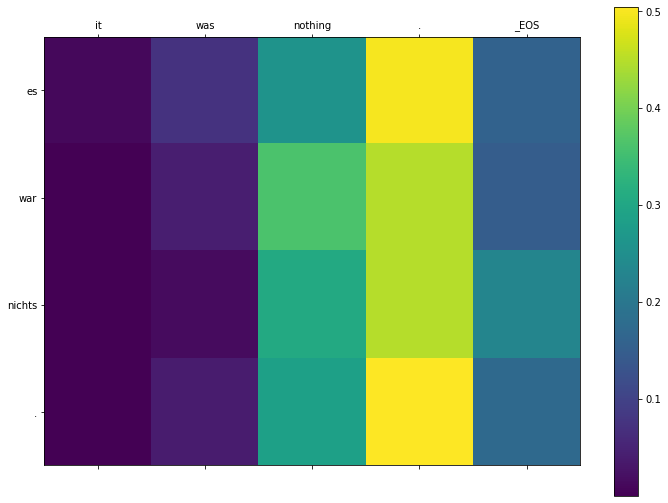

In [18]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    # Choose a random sentences
    i = random.randint(0,len(en_inputs)-1)
    h = encoder.init_hidden()
    inp = torch.tensor(en_inputs[i]).unsqueeze(0).to(device)
    encoder_outputs, h = encoder(inp,h)

    decoder_input = torch.tensor([en_w2i['_SOS']],device=device)
    decoder_hidden = h
    output = []
    attentions = []
    while True:
        decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
        _, top_index = decoder_output.topk(1)
        decoder_input = torch.tensor([top_index.item()],device=device)
        
        #If the decoder output is the End Of Sentence token, stop decoding process
        if top_index.item() == de_w2i["_EOS"]:
            break
        output.append(top_index.item())
        attentions.append(attn_weights.squeeze().cpu().detach().numpy())

print("English: "+ " ".join([en_i2w[x] for x in en_inputs[i]]))
print("Predicted: " + " ".join([de_i2w[x] for x in output]))
print("Actual: " + " ".join([de_i2w[x] for x in de_inputs[i]]))

# Plotting the heatmap for the Attention weights
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
cax = ax.matshow(np.array(attentions))
fig.colorbar(cax)
ax.set_xticklabels(['']+[en_i2w[x] for x in en_inputs[i]])
ax.set_yticklabels(['']+[de_i2w[x] for x in output])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

## Interpreting the attention mechanism

You should obtain a figure where:
- Each row corresponds to an output word in german
- Each column corresponds to an input word in english.
- The pixel intensity corresponds to the weight of the input word in the output word prediction assigned by the attention mechanism.

## Remarks

From the example above, we can see that for each output word from the decoder, the weights assigned to the input words are different and we can see the relationship between the inputs and outputs that the model is able to draw. You can try this on a few more examples to test the results of the translator.

In our training, we have clearly overfitted our model to the training sentences. If we were to test the trained model on sentences it has never seen before, it is unlikely to produce decent results. Nevertheless this process acts as a sanity check to ensure that our model works and is able to function end-to-end and learn.

The challenge of training an effective model can be attributed largely to the lack of training data and training time. Due to the complex nature of the different languages involved and large number of vocabulary and grammatical permutations, an effective model will require tons of data and training time before any results can be seen on evaluation data.
